# 0. Install Dependencies and Bring in Data

In [1]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

^C


In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [5]:
!pip list

Package                            Version
---------------------------------- -------------------
absl-py                            1.0.0
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 2.0.3
anaconda-project                   0.9.1
anyio                              2.2.0
appdirs                            1.4.4
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astroid                            2.5
astropy                            4.2.1
astunparse                         1.6.3
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              20.3.0
autopep8                           1.5.6
Babel                              2.9.0
backcall                           0.2.0
backports.functools-lru-cache      1.6.4
backports.shutil-get-terminal-size 1.0.0
backports.tempfile                 1.0
b

In [6]:
from tensorflow.keras.layers import TextVectorization


diff-match-patch                   20200713
distributed                        2021.4.0
docutils                           0.17
entrypoints                        0.3
et-xmlfile                         1.0.1
fastcache                          1.1.0
filelock                           3.0.12
flake8                             3.9.0
Flask                              1.1.2
flatbuffers                        2.0
fsspec                             0.9.0
future                             0.18.2
gast                               0.4.0
gevent                             21.1.2
glob2                              0.7
google-auth                        2.5.0
google-auth-oauthlib               0.4.6
google-pasta                       0.2.0
greenlet                           1.0.0
grpcio                             1.43.0
h5py                               2.10.0
HeapDict                           1.0.1
html5lib                           1.1
idna                               2.10
imagecodecs   

In [7]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [8]:
MAX_FEATURES = 200000 # number of words in the vocab

In [9]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

  Using cached tensorflow-2.8.0-cp38-cp38-win_amd64.whl (438.0 MB)
  Using cached sklearn-0.0-py2.py3-none-any.whl


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Public\\anaconda3\\Lib\\site-packages\\tensorflow\\lite\\experimental\\microfrontend\\python\\ops\\_audio_microfrontend_op.so'
Consider using the `--user` option or check the permissions.



In [10]:
vectorizer.adapt(X.values)

In [11]:
vectorized_text = vectorizer(X.values)

In [12]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [13]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [15]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [16]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [18]:
history = model.fit(train, epochs=7, validation_data=val)

Epoch 1/7
6981/6981 [==============================] - 795s 110ms/step - loss: 0.0633 - val_loss: 0.0475
Epoch 2/7
6981/6981 [==============================] - 721s 103ms/step - loss: 0.0455 - val_loss: 0.0398
Epoch 3/7
6981/6981 [==============================] - 718s 103ms/step - loss: 0.0403 - val_loss: 0.0361
Epoch 4/7
6981/6981 [==============================] - 734s 105ms/step - loss: 0.0361 - val_loss: 0.0305
Epoch 5/7
6981/6981 [==============================] - 975s 140ms/step - loss: 0.0319 - val_loss: 0.0274
Epoch 6/7
6981/6981 [==============================] - 1210s 173ms/step - loss: 0.0282 - val_loss: 0.0244
Epoch 7/7
6981/6981 [==============================] - 825s 118ms/step - loss: 0.0249 - val_loss: 0.0221


In [19]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

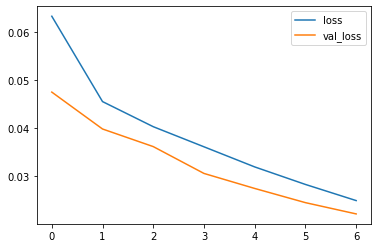

In [20]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [21]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [22]:
res = model.predict(input_text)

ValueError: in user code:

    File "C:\Users\Public\anaconda3\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Public\anaconda3\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Public\anaconda3\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Public\anaconda3\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\Public\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Public\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 214, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential" (type Sequential).
    
    Input 0 of layer "bidirectional" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 32)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None,), dtype=int64)
      • training=False
      • mask=None


In [23]:
(res > 0.5).astype(int)

NameError: name 'res' is not defined

In [24]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [25]:
(model.predict(batch_X) > 0.5).astype(int)

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [26]:
res.shape

NameError: name 'res' is not defined

# 4. Evaluate Model

In [27]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [28]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [29]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [30]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9017214179039001, Recall:0.8357992172241211, Accuracy:0.520561695098877


# 5. Test and Gradio

In [32]:
!pip install gradio jinja2

  Using cached multidict-6.0.2-cp38-cp38-win_amd64.whl (28 kB)
  Using cached yarl-1.7.2-cp38-cp38-win_amd64.whl (122 kB)


In [33]:
import tensorflow as tf
import gradio as gr

  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4709 sha256=252cd349c382efbf71b7353991adc17b333e4266bc8078eaf836f72e0f5764fd
  Stored in directory: c:\users\suvayan nath\appdata\local\pip\cache\wheels\ff\5b\59\913b443e7369dc04b61f607a746b6f7d83fb65e2e19fcc958d
  Created wheel for python-multipart: filename=python_multipart-0.0.5-py3-none-any.whl size=31670 sha256=04b0364b7fc50aa1289c03a1275da3d38091423f70fbd78e0e88b08c950fa073
  Stored in directory: c:\users\suvayan nath\appdata\local\pip\cache\wheels\9e\fc\1c\cf980e6413d3ee8e70cd8f39e2366b0f487e3e221aeb452eb0
Successfully built ffmpy python-multipart
  Attempting uninstall: anyio
    Found existing installation: anyio 2.2.0
    Uninstalling anyio-2.2.0:
      Successfully uninstalled anyio-2.2.0


In [31]:
model.save('toxicity1.h5')

In [34]:
model = tf.keras.models.load_model('toxicity1.h5')

In [35]:
input_str = vectorizer('hey i freaken hate you!')

In [36]:
res = model.predict(np.expand_dims(input_str,0))

In [37]:
res

array([[0.84784985, 0.00290528, 0.0223191 , 0.0076618 , 0.17252244,
        0.0381235 ]], dtype=float32)

In [38]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [39]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [40]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860/
Running on public URL: https://50281.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x1c4bbeb0d90>,
 'http://127.0.0.1:7860/',
 'https://50281.gradio.app')